In [1]:
import sqlite3

from Hw4.data_predprocessing import preprocess_text
import pandas as pd

# Подключение к базе данных (файл будет создан автоматически)
conn = sqlite3.connect('tweets_db.db')
cursor = conn.cursor()

# Создание таблицы passengers
cursor.execute('''
CREATE TABLE IF NOT EXISTS tweets (
    target INTEGER,
    ids INTEGER,
    date TEXT,
    flag TEXT,
    user TEXT,
    text TEXT
)
''')

conn.commit()

# Загрузка CSV-файла в DataFrame
df = pd.read_csv('../Hw3/training.1600000.processed.noemoticon.csv',
                 encoding='latin-1',
                 header=None,
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'])

# Применяем предобработку к тексту
print("Предобработка текста...")
df['text'] = df['text'].apply(preprocess_text)

# Импорт DataFrame в SQLite
df.to_sql('tweets', conn, if_exists='replace', index=False)

# Проверка первых 5 записей
query = "SELECT * FROM tweets LIMIT 5;"
print(pd.read_sql_query(query, conn))

conn.close()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Предобработка текста...
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  awww thats bummer shoulda got david carr third...  
1    scotthamilton  upset cant update facebook texting might cry r...  
2         mattycus     dived many times ball managed save rest bounds  
3          ElleCTF                   whole body feels itchy like fire  
4           Karoli                              behaving mad cant see  


In [ ]:
from data_select import TweetsDatabase

db = TweetsDatabase('tweets_db.db')

# Получение статистики
stats = db.get_number_of_tweets_by_target()
for item in stats:
    print(f"Полярность твита {item['target']}: {item['count']} количество")

# Получить рандомные 100 твитов
tweets = db.get_first_hundred_tweets()
print("\nВыборка 100 рандомных твитов:")
for tweet in tweets:
    print(
        f"Полярность твита:{tweet['target']}/ ID:{tweet['ids']}/ Дата:{tweet['date']}/ Пользователь:{tweet['user']}/ Текст: {tweet['text']}")

# Пользователи с наибольшим количеством негативных твитов
negative_tweets = db.get_user_with_negative_tweets(20)
print("\nВыборка 20 негативных твитов:")
for tweet in negative_tweets:
    print(f"Пользователь {tweet['user']}: {tweet['negative_count']} количество")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Размер датасета после очистки: (1487308, 6)
Векторизация текста...
Размерность признаков: (1487308, 5000)
Обучающая выборка: 1189846 samples
Тестовая выборка: 297462 samples
Обучение CatBoost классификатора...
0:	learn: 0.6860488	test: 0.6860107	best: 0.6860107 (0)	total: 1.71s	remaining: 28m 29s
100:	learn: 0.5822651	test: 0.5828467	best: 0.5828467 (100)	total: 2m 44s	remaining: 24m 25s
200:	learn: 0.5556496	test: 0.5567875	best: 0.5567875 (200)	total: 4m 48s	remaining: 19m 5s
300:	learn: 0.5400921	test: 0.5418430	best: 0.5418430 (300)	total: 6m 50s	remaining: 15m 53s
400:	learn: 0.5295027	test: 0.5317736	best: 0.5317736 (400)	total: 8m 48s	remaining: 13m 10s
500:	learn: 0.5214847	test: 0.5241694	best: 0.5241694 (500)	total: 10m 51s	remaining: 10m 48s
600:	learn: 0.5151109	test: 0.5182479	best: 0.5182479 (600)	total: 12m 58s	remaining: 8m 37s
700:	learn: 0.5098668	test: 0.5134177	best: 0.5134177 (700)	total: 15m 1s	remaining: 6m 24s
800:	learn: 0.5053882	test: 0.5093690	best: 0.509369

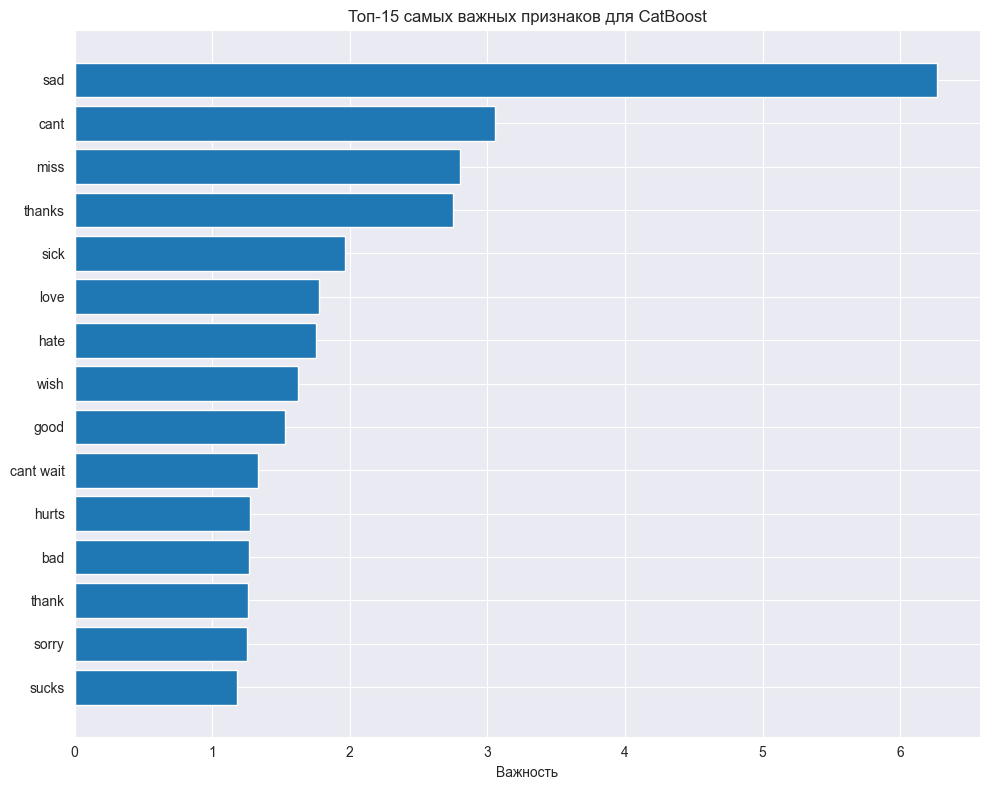

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import nltk

nltk.download('punkt_tab')

conn = sqlite3.connect('tweets_db.db')
df = pd.read_sql('SELECT * FROM tweets', conn)
conn.close()

# Удаляем пустые тексты после очистки
df = df[df['text'].str.len() > 10]
print(f"Размер датасета после очистки: {df.shape}")

# Создаем TF-IDF векторизатор
vectorizer = TfidfVectorizer(
    max_features=5000,  # Ограничиваем количество признаков для скорости
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

print("Векторизация текста...")
X = vectorizer.fit_transform(df['text'])
y = df['target']

print(f"Размерность признаков: {X.shape}")

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")

# Создаем и обучаем модель CatBoost
print("Обучение CatBoost классификатора...")

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,  # Вывод каждые 100 итераций
    random_state=42,
    thread_count=-1  # Используем все доступные ядра
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    verbose=100
)

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Метрики качества
print("\n" + "=" * 50)
print("РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ")
print("=" * 50)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Получаем важность признаков
feature_importance = model.get_feature_importance()
feature_names = vectorizer.get_feature_names_out()

# Создаем DataFrame с важностью признаков
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nТоп-20 самых важных признаков:")
print(importance_df.head(20))

# Визуализация важности признаков
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Важность')
plt.title('Топ-15 самых важных признаков для CatBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Уникальные значения в target: [0 1]
Количество уникальных классов: 2
Accuracy: 0.7021

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68    160000
           1       0.68      0.76      0.72    160000

    accuracy                           0.70    320000
   macro avg       0.71      0.70      0.70    320000
weighted avg       0.71      0.70      0.70    320000


Confusion Matrix:
[[102610  57390]
 [ 37924 122076]]


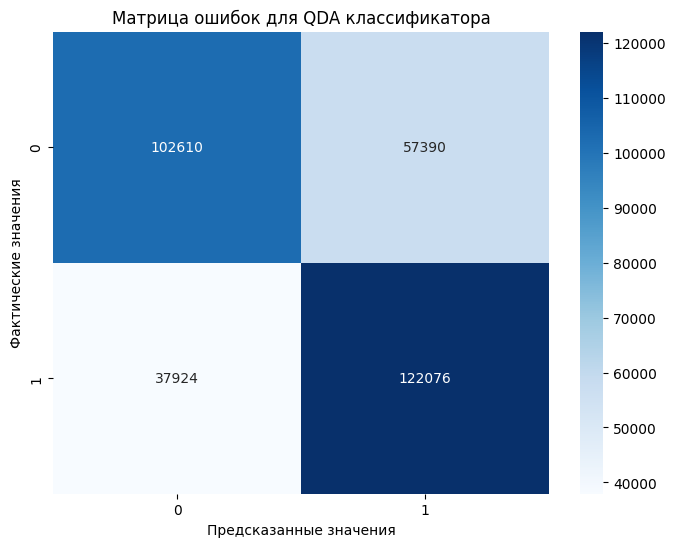

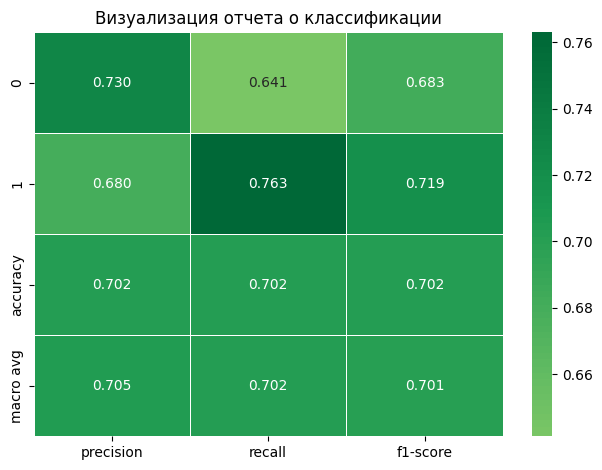

In [9]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


conn = sqlite3.connect('tweets_db.db')
df = pd.read_sql('SELECT * FROM tweets', conn)
conn.close()

# Удаляем строки с NaN в исходном целевом столбце (до преобразования)
df = df.dropna(subset=['target'])

# Затем выполняем преобразование меток
df['target'] = df['target'].map({0: 0, 4: 1})

# Проверяем уникальные значения и их количество
unique_values = df['target'].unique()
print("Уникальные значения в target:", unique_values)
print("Количество уникальных классов:", len(unique_values))

# Разделение на признаки (X) и целевую переменную (y)
X = df['text']
y = df['target']

# Преобразование текста в числовые признаки
vectorizer = TfidfVectorizer(max_features=500)
X_vectorized = vectorizer.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

# Создание и обучение модели QDA
qda = QuadraticDiscriminantAnalysis()
# ЗАМЕНА ПРЯМОГО ПРЕОБРАЗОВАНИЯ X_train.toarray()
# Создаем memory-mapped файл для плотной матрицы
X_train_dense = np.memmap('X_train_memmap.dat', dtype=np.float64, mode='w+', shape=X_train.shape)

# Записываем данные из разреженной матрицы в memory-mapped массив
X_train_dense[:] = X_train.toarray()

# Обучаем модель, используя memory-mapped массив
qda.fit(X_train_dense, y_train)

# После обучения освобождаем ресурсы
del X_train_dense

# Предсказание на тестовых данных
# Создаем memory-mapped файл для тестовых данных
X_test_dense = np.memmap('X_test_memmap.dat', dtype=np.float64, mode='w+', shape=X_test.shape)
X_test_dense[:] = X_test.toarray()

# Предсказание на тестовых данных
y_pred = qda.predict(X_test_dense)
y_p_proba = qda.predict_proba(X_test_dense)

# Освобождаем ресурсы
del X_test_dense

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Оценка модели
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Создание и отображение матрицы ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок для QDA классификатора')
plt.show()

# Визуализация отчета о классификации
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-1, :]  # Исключаем итоги

sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap='RdYlGn',
            center=0.5, fmt='.3f', linewidths=0.5)
plt.title('Визуализация отчета о классификации')
plt.tight_layout()
plt.show()


Типы данных в 'text': text
<class 'str'>    1600000
Name: count, dtype: int64
Удалено строк с нестроковыми значениями в text: 0
Распределение sentiment:
sentiment
negative    800000
positive    800000
Name: count, dtype: int64
Удалено строк с NaN в target: 0
Размер выборки: 1000
Размерность признаков: (1000, 3000)
Классы: ['negative' 'positive']
Тренировочная выборка: (700, 3000)
Тестовая выборка: (300, 3000)

Точность модели: 0.6367

Отчет по классификации:
              precision    recall  f1-score   support

    negative       0.67      0.53      0.59       149
    positive       0.62      0.74      0.67       151

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.63       300
weighted avg       0.64      0.64      0.63       300



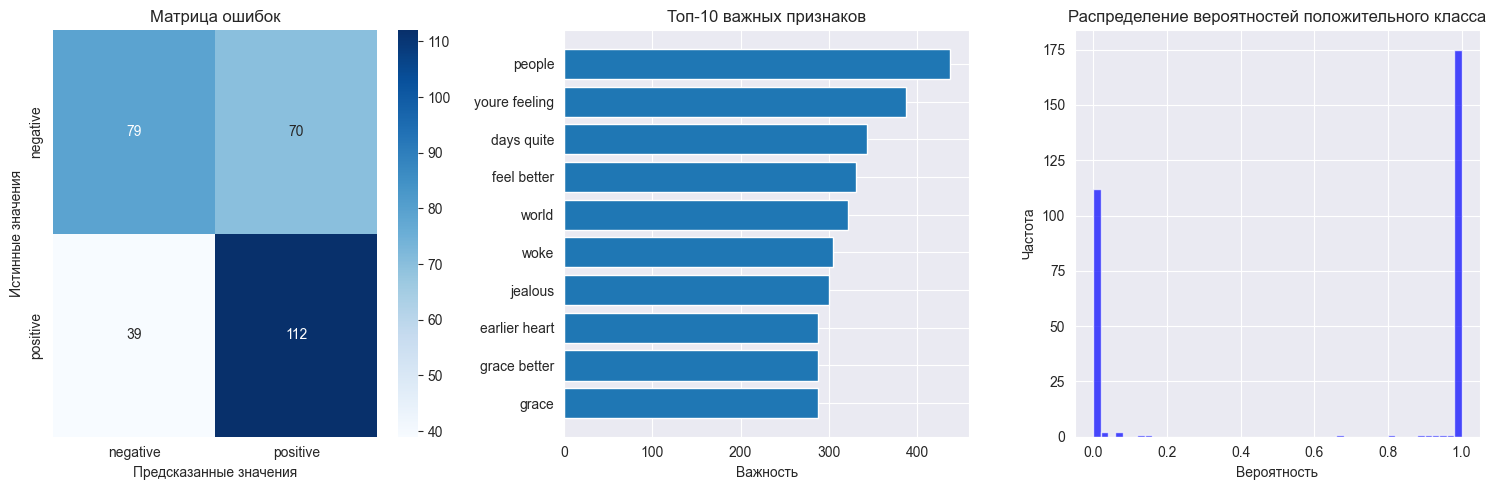

In [20]:
import sqlite3
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('tweets_db.db')
df = pd.read_sql('SELECT * FROM tweets', conn)
conn.close()

# Проверяем, есть ли в столбце не-строки (например, float/NaN)
print("Типы данных в 'text':", df['text'].apply(type).value_counts())

# Удаляем строки, где cleaned_text является float (например, NaN)
initial_count = len(df)
df = df[df['text'].apply(lambda x: isinstance(x, str))]
print(f"Удалено строк с нестроковыми значениями в text: {initial_count - len(df)}")

# На всякий случай преобразуем все оставшиеся значения в строки
df['text'] = df['text'].astype(str)

# Преобразуем целевые переменные (0 - negative, 4 - positive)
df['sentiment'] = df['target'].map({0: 'negative', 4: 'positive'})

print("Распределение sentiment:")
print(df['sentiment'].value_counts())

# Удаляем строки с NaN в целевом столбце
initial_count = len(df)
df = df.dropna(subset=['target'])
print(f"Удалено строк с NaN в target: {initial_count - len(df)}")


# Для больших данных возьмем под - выборку для демонстрации
sample_size = min(1000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

print(f"Размер выборки: {len(df_sample)}")

# Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df_sample['text'])

# Преобразуем в плотную матрицу (может потребовать много памяти для больших данных)
X = X_tfidf.toarray()
y = df_sample['sentiment']

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Размерность признаков: {X.shape}")
print(f"Классы: {label_encoder.classes_}")

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Тренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Создание и обучение модели LDA
lda = lda = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, tol=0.0001)
lda.fit(X_train, y_train)

# Прогнозирование
y_p = lda.predict(X_test)
y_p_proba = lda.predict_proba(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_p)
print(f"\nТочность модели: {accuracy:.4f}")
print("\nОтчет по классификации:")
print(classification_report(y_test, y_p, target_names=label_encoder.classes_))

# Матрица ошибок
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_p)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')

# Важность признаков (коэффициенты LDA)
plt.subplot(1, 3, 2)
feature_importance = np.abs(lda.coef_[0])
top_features_idx = np.argsort(feature_importance)[-10:]
top_features_names = [vectorizer.get_feature_names_out()[i] for i in top_features_idx]
top_features_importance = feature_importance[top_features_idx]

plt.barh(range(len(top_features_importance)), top_features_importance)
plt.yticks(range(len(top_features_importance)), top_features_names)
plt.title('Топ-10 важных признаков')
plt.xlabel('Важность')

# Распределение вероятностей
plt.subplot(1, 3, 3)
positive_probs = y_p_proba[:, 1]
plt.hist(positive_probs, bins=50, alpha=0.7, color='blue')
plt.title('Распределение вероятностей положительного класса')
plt.xlabel('Вероятность')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()



In [1]:
import sqlite3
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

conn = sqlite3.connect('tweets_db.db')
df = pd.read_sql('SELECT * FROM tweets', conn)
conn.close()

# Проверяем, есть ли в столбце не-строки (например, float/NaN)
print("Типы данных в 'text':", df['text'].apply(type).value_counts())

# Удаляем строки, где cleaned_text является float (например, NaN)
initial_count = len(df)
df = df[df['text'].apply(lambda x: isinstance(x, str))]
print(f"Удалено строк с нестроковыми значениями в text: {initial_count - len(df)}")

# На всякий случай преобразуем все оставшиеся значения в строки
df['text'] = df['text'].astype(str)

# Выбор признаков и целевой переменной
X = df['text']  # Тексты твитов
y = df['target']  # Метки настроений

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Преобразование текстов в числовые признаки с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)  # Ограничение количества признаков для скорости
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)


clf = DecisionTreeClassifier(max_depth=20,
                             min_samples_split=20,
                             min_samples_leaf=10,
                             random_state=42)
clf.fit(X_train_vect, y_train)

y_pred = clf.predict(X_test_vect)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Типы данных в 'text': text
<class 'str'>    1600000
Name: count, dtype: int64
Удалено строк с нестроковыми значениями в text: 0
Accuracy: 0.62466875

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.33      0.47    159494
           4       0.58      0.92      0.71    160506

    accuracy                           0.62    320000
   macro avg       0.69      0.62      0.59    320000
weighted avg       0.69      0.62      0.59    320000



Типы данных в 'text': text
<class 'str'>    1600000
Name: count, dtype: int64
Удалено строк с нестроковыми значениями в text: 0
WordCloud для позитивных твитов:


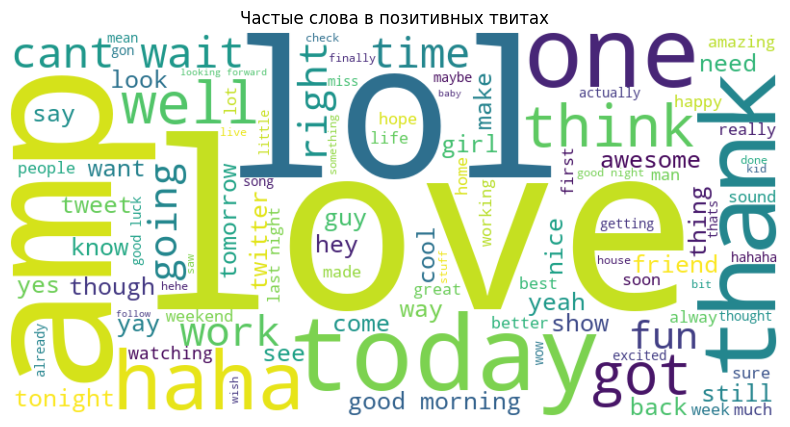

WordCloud для негативных твитов:


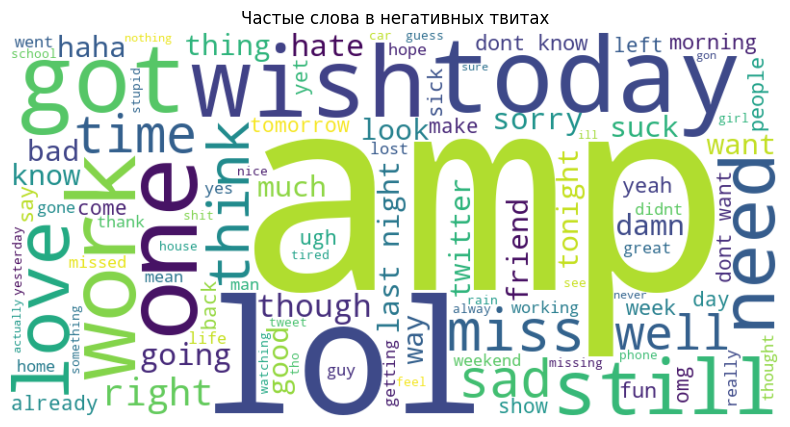

ИТОГОВАЯ СТАТИСТИКА МОДЕЛИ
Точность модели: 0.7473
Количество признаков: 1000
Размер обучающей выборки: 1,120,000
Размер тестовой выборки: 480,000

Детальный отчет по классификации:
              precision    recall  f1-score   support

  Негативные       0.76      0.71      0.74    239361
  Позитивные       0.73      0.78      0.76    240639

    accuracy                           0.75    480000
   macro avg       0.75      0.75      0.75    480000
weighted avg       0.75      0.75      0.75    480000


Примеры предсказаний:

Текст: air conditioner car finally course would get done rainest week ever dont even need lol...
Истинный: Позитивный, Предсказанный: Позитивный
Уверенность: 0.5264

Текст: quoti cant seem find sense disregard lord knows hurting feel benign control thisquot...
Истинный: Негативный, Предсказанный: Негативный
Уверенность: 0.8905

Текст: haha omg thinking thing sure going kiss upset...
Истинный: Негативный, Предсказанный: Негативный
Уверенность: 0.7417

Текст: frida

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
import re
import sqlite3

# Создание WordCloud для позитивных и негативных твитов
def generate_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(' '.join(texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

conn = sqlite3.connect('tweets_db.db')
df = pd.read_sql('SELECT * FROM tweets', conn)
conn.close()

#Проверяем, есть ли в столбце не-строки (например, float/NaN)
print("Типы данных в 'text':", df['text'].apply(type).value_counts())

# Удаляем строки с NaN в исходном целевом столбце (до преобразования)
df = df.dropna(subset=['target'])

# Затем выполняем преобразование меток
df['target'] = df['target'].map({0: 0, 4: 1})

# Удаляем строки, где cleaned_text является float (например, NaN)
initial_count = len(df)
df = df[df['text'].apply(lambda x: isinstance(x, str))]
print(f"Удалено строк с нестроковыми значениями в text: {initial_count - len(df)}")

# На всякий случай преобразуем все оставшиеся значения в строки
df['text'] = df['text'].astype(str)

# Выбор признаков и целевой переменной
X = df['text']  # Тексты твитов
y = df['target']  # Метки настроений


X_train, X_test, y_train, y_test = train_test_split(
    df['text'],  # Очищенный текст
    df['target'],    # Метка тональности
    test_size=0.3,
    random_state=42    # Для воспроизводимости результатов
)

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out()
# Создание и обучение модели
logreg = LogisticRegression(max_iter=1000)  # max_iter для сходимости
logreg.fit(X_train_tfidf, y_train)

# Прогнозирование на тестовой выборке
y_pred = logreg.predict(X_test_tfidf)
y_pred_proba = logreg.predict_proba(X_test_tfidf)[:, 1]

# Визуализация
positive_texts = df[df['target'] == 1]['text']
negative_texts = df[df['target'] == 0]['text']

print("WordCloud для позитивных твитов:")
generate_wordcloud(positive_texts, 'Частые слова в позитивных твитах')

print("WordCloud для негативных твитов:")
generate_wordcloud(negative_texts, 'Частые слова в негативных твитах')

# Статистика
accuracy = accuracy_score(y_test, y_pred)
print("=" * 50)
print("ИТОГОВАЯ СТАТИСТИКА МОДЕЛИ")
print("=" * 50)
print(f"Точность модели: {accuracy:.4f}")
print(f"Количество признаков: {len(feature_names)}")
print(f"Размер обучающей выборки: {len(X_train):,}")
print(f"Размер тестовой выборки: {len(X_test):,}")

# Отчет по классификации
print("\nДетальный отчет по классификации:")
print(classification_report(y_test, y_pred, target_names=['Негативные', 'Позитивные']))

# Примеры предсказаний
print("\nПримеры предсказаний:")
sample_idx = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_idx:
    actual = "Позитивный" if y_test.iloc[idx] == 1 else "Негативный"
    predicted = "Позитивный" if y_pred[idx] == 1 else "Негативный"
    confidence = y_pred_proba[idx] if y_pred[idx] == 1 else 1 - y_pred_proba[idx]

    print(f"\nТекст: {X_test.iloc[idx][:100]}...")
    print(f"Истинный: {actual}, Предсказанный: {predicted}")
    print(f"Уверенность: {confidence:.4f}")

In [1]:
import sqlite3
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


conn = sqlite3.connect('tweets_db.db')
df = pd.read_sql('SELECT * FROM tweets', conn)
conn.close()

# Удаляем строки с NaN в исходном целевом столбце (до преобразования)
df = df.dropna(subset=['target'])

# Затем выполняем преобразование меток
df['target'] = df['target'].map({0: 0, 4: 1})

# Проверяем уникальные значения и их количество
unique_values = df['target'].unique()
print("Уникальные значения в target:", unique_values)
print("Количество уникальных классов:", len(unique_values))

# Векторизация текста
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['text']).toarray()
y = df['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создание и обучение модели
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=25,
    learning_rate=0.05,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss'
)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Детальный отчет по классификации
print(classification_report(y_test, y_pred))


Уникальные значения в target: [0 1]
Количество уникальных классов: 2
[LightGBM] [Info] Number of positive: 599581, number of negative: 600419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.531039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112820
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499651 -> initscore=-0.001397
[LightGBM] [Info] Start training from score -0.001397


C:\Users\user\PycharmProjects\DataScienceProj\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.7092
              precision    recall  f1-score   support

           0       0.77      0.59      0.67    199581
           1       0.67      0.83      0.74    200419

    accuracy                           0.71    400000
   macro avg       0.72      0.71      0.71    400000
weighted avg       0.72      0.71      0.71    400000

